# Session 6 - Decision Trees and Ensemble Learning - Homework
#### By Quynh Le

Part of the [Machine Learning Zoomcamp (September 2021 – December 2021)](https://datatalks.club/courses/2021-winter-ml-zoomcamp.html)



## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [3]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv

--2021-10-19 22:22:35--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: 'AB_NYC_2019.csv'

     0K .......... .......... .......... .......... ..........  0% 1.58M 4s
    50K .......... .......... .......... .......... ..........  1%  186K 20s
   100K .......... .......... .......... .......... ..........  2% 85.3M 14s
   150K .......... .......... .......... .......... ..........  2%  123M 10s
   200K .......... .......... .......... .......... ..........  3% 66.0M 8s
   250K .......... .......... .......... .......... ..........  4% 1.56M 7s
   300K .......... .......... .......... .......... ..........  5% 8.51M 6s
   350K .......... ..

In [3]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [4]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [5]:
df.shape

(48895, 10)

In [6]:
df.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

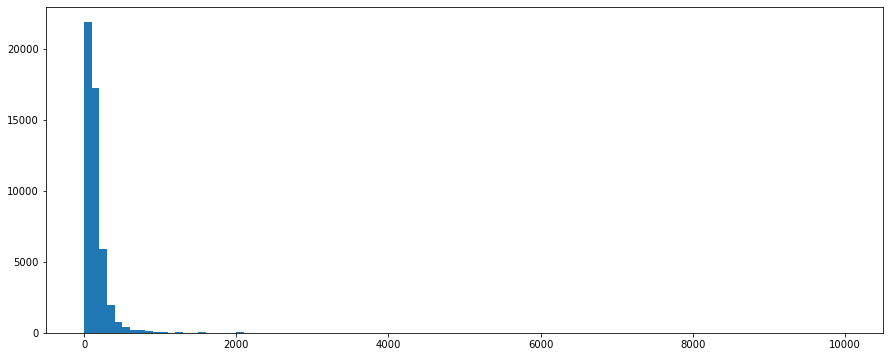

In [7]:
plt.figure(figsize=(15, 6))
plt.hist(df.price, bins = 100);

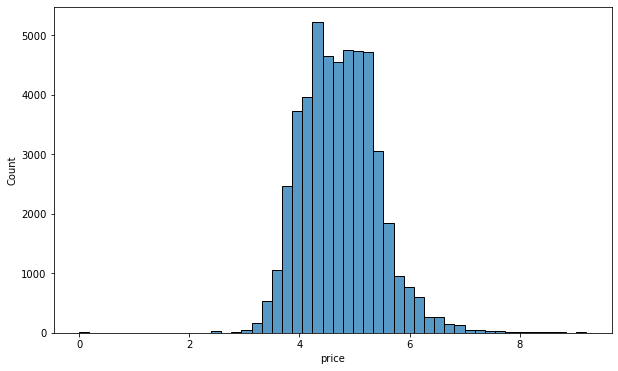

In [8]:
plt.figure(figsize = (10, 6))
sns.histplot(np.log1p(df.price), bins = 50);

In [9]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [10]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']   
del df_val['price']
del df_test['price']

In [11]:
print(len(df_train), len(df_val), len(df_test), len(y_train), len(y_val), len(y_test))

29337 9779 9779 29337 9779 9779


Now, use `DictVectorizer` to turn train and validation into matrices:

In [13]:
train_dicts = df_train.to_dict(orient='records')

In [14]:
dv = DictVectorizer(sparse=False)

In [15]:
X_train = dv.fit_transform(train_dicts)

In [16]:
val_dicts = df_val.to_dict(orient='records')

In [17]:
X_val = dv.transform(val_dicts)

In [18]:
X_train.shape

(29337, 15)

In [19]:
X_val.shape

(9779, 15)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [20]:
regressor = DecisionTreeRegressor(max_depth=1)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [21]:
y_pred = regressor.predict(X_val)

In [22]:
text_rep = export_text(regressor, feature_names=dv.get_feature_names())
print(text_rep)

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

Answer: 'room_type' is used for splitting the data when max_depth = 1 (decision stump).

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [23]:
rf = RandomForestRegressor(n_estimators=10, 
                           random_state=1, 
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [24]:
y_pred = rf.predict(X_val)

In [25]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))

Root Mean Squared Error: 0.4615632303514057


What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

Answer: 0.459 (closest to my calculation 0.461)

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [26]:
n_estimators_range = np.arange(10, 201, 10)
n_estimators_range

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])

In [27]:
scores = []

for n in n_estimators_range:
    
    rf = RandomForestRegressor(n_estimators=n, 
                               random_state=1, 
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(metrics.mean_squared_error(y_val, y_pred))
    scores.append((n, rmse))

In [28]:
scores

[(10, 0.4615632303514057),
 (20, 0.4481844037246563),
 (30, 0.445534982591036),
 (40, 0.4436370400686574),
 (50, 0.4423252158693789),
 (60, 0.4416390063083674),
 (70, 0.4412400708145094),
 (80, 0.4411253881867737),
 (90, 0.44055067262951675),
 (100, 0.4399734361245008),
 (110, 0.43947286054175283),
 (120, 0.43923581828746266),
 (130, 0.4393024606141518),
 (140, 0.4390088112588317),
 (150, 0.4389016090216187),
 (160, 0.438700402552987),
 (170, 0.4386273317291687),
 (180, 0.43876507353873545),
 (190, 0.4387232276613794),
 (200, 0.4387504763480828)]

In [29]:
df_score = pd.DataFrame(scores, columns = ['n_estimators', 'RMSE'])
df_score

,n_estimators,RMSE
0,10,0.461563
1,20,0.448184
2,30,0.445535
3,40,0.443637
4,50,0.442325
5,60,0.441639
6,70,0.441240
7,80,0.441125
8,90,0.440551
9,100,0.439973


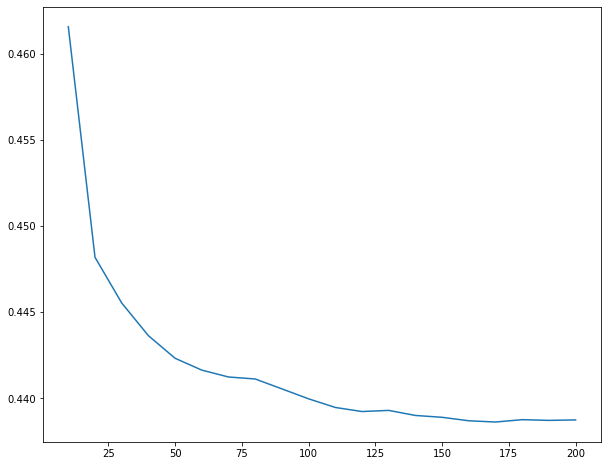

In [30]:
plt.figure(figsize = (10, 8))
plt.plot(df_score.n_estimators, df_score.RMSE)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

Answer: When n_estimators is around 120 that RMSE stops improving as the graph shows.

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [31]:
scores = []

In [32]:
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):

        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth = d,
                                   random_state=1,
                                   n_jobs = -1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(metrics.mean_squared_error(y_val, y_pred))
        scores.append((n, d, rmse))

In [33]:
scores

[(10, 10, 0.44555264855924354),
 (20, 10, 0.4420087608705588),
 (30, 10, 0.4413808076445009),
 (40, 10, 0.44147246709402543),
 (50, 10, 0.4410673887594955),
 (60, 10, 0.4410459421233984),
 (70, 10, 0.4407598704010177),
 (80, 10, 0.4405950365838957),
 (90, 10, 0.4403250798157756),
 (100, 10, 0.4401137602802354),
 (110, 10, 0.44002599123352587),
 (120, 10, 0.4398178667293093),
 (130, 10, 0.4398547755113232),
 (140, 10, 0.43984985853331104),
 (150, 10, 0.43969001659014506),
 (160, 10, 0.4396442598915558),
 (170, 10, 0.43962394971115537),
 (180, 10, 0.4397169310258638),
 (190, 10, 0.4396683937380781),
 (200, 10, 0.43967858051302805),
 (10, 15, 0.45014955224590053),
 (20, 15, 0.4413965306029092),
 (30, 15, 0.4398942644411996),
 (40, 15, 0.43928475526633337),
 (50, 15, 0.43835155877923293),
 (60, 15, 0.4379833031193405),
 (70, 15, 0.43745781237443004),
 (80, 15, 0.43726812528767756),
 (90, 15, 0.4368731254920105),
 (100, 15, 0.43651230928156826),
 (110, 15, 0.43628106735528754),
 (120, 15, 0

In [34]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'rmse'])
df_scores.head()

,n_estimators,max_depth,rmse
0,10,10,0.445553
1,20,10,0.442009
2,30,10,0.441381
3,40,10,0.441472
4,50,10,0.441067


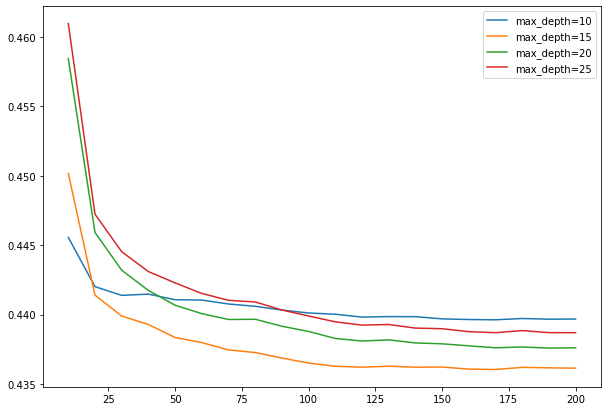

In [35]:
plt.figure(figsize = (10, 7))

for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)
plt.legend();

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

Answer: The best max_depth is 15.

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [36]:
rf = RandomForestRegressor(n_estimators=10, 
                           max_depth = 20,
                           random_state=1, 
                           n_jobs=-1)

In [37]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [38]:
importance = rf.feature_importances_

In [43]:
importance

array([7.62639474e-02, 3.01019255e-02, 1.52775354e-01, 1.54100960e-01,
       5.32519176e-02, 2.64845849e-04, 9.65959537e-04, 3.40472718e-02,
       1.16609902e-03, 8.40278947e-05, 4.15942415e-02, 5.44303877e-02,
       3.91898194e-01, 4.03202776e-03, 5.02284130e-03])

In [39]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.07626
Feature: 1, Score: 0.03010
Feature: 2, Score: 0.15278
Feature: 3, Score: 0.15410
Feature: 4, Score: 0.05325
Feature: 5, Score: 0.00026
Feature: 6, Score: 0.00097
Feature: 7, Score: 0.03405
Feature: 8, Score: 0.00117
Feature: 9, Score: 0.00008
Feature: 10, Score: 0.04159
Feature: 11, Score: 0.05443
Feature: 12, Score: 0.39190
Feature: 13, Score: 0.00403
Feature: 14, Score: 0.00502


In [42]:
dv.get_feature_names()

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood_group=Bronx',
 'neighbourhood_group=Brooklyn',
 'neighbourhood_group=Manhattan',
 'neighbourhood_group=Queens',
 'neighbourhood_group=Staten Island',
 'number_of_reviews',
 'reviews_per_month',
 'room_type=Entire home/apt',
 'room_type=Private room',
 'room_type=Shared room']

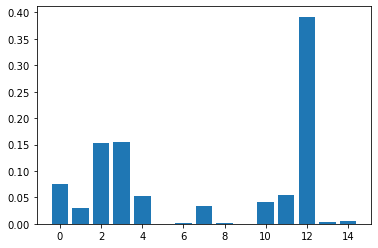

In [40]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

The most important feature is feature 12 or 'room_type=Entire home/apt'. 

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [44]:
!pip install xgboost

In [45]:
import xgboost as xgb

In [46]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [47]:
watchlist = [(dtrain, 'train'), (dval, 'val')]   

In [60]:
scores = {}

In [70]:
%%capture output 

xgb_params = {
    'eta': 0.01,                
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1, 
    'verbosity': 1,            
    
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [62]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
        
    return df_results

In [71]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [72]:
scores['eta=0.01']

,num_iter,train_rmse,val_rmse
0,0,4.25336,4.25010
1,1,4.21141,4.20815
2,2,4.16988,4.16661
3,3,4.12877,4.12551
4,4,4.08807,4.08481
...,...,...,...
95,95,1.69373,1.69214
96,96,1.67804,1.67647
97,97,1.66251,1.66095
98,98,1.64716,1.64563


In [73]:
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1', 'eta=0.01'])

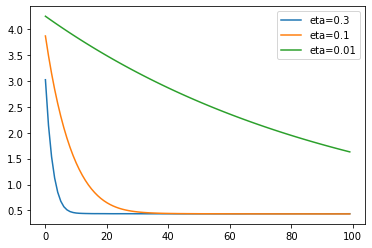

In [74]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)
plt.legend()

Now change `eta` first to `0.1` and then to `0.01`

What's the best eta?

* 0.3
* 0.1
* 0.01

Answer: The best eta is 0.3 as RMSE decreases most quickly and reaches lowest value with eta = 0.3

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

